# Large-scale multi-label text classification

**Author:** [Sayak Paul](https://twitter.com/RisingSayak), [Soumik Rakshit](https://github.com/soumik12345)<br>
**Date created:** 2020/09/25<br>
**Last modified:** 2020/12/23<br>
**Description:** Implementing a large-scale multi-label text classification model.

## Introduction

In this example, we will build a multi-label text classifier to predict the subject areas
of arXiv papers from their abstract bodies. This type of classifier can be useful for
conference submission portals like [OpenReview](https://openreview.net/). Given a paper
abstract, the portal could provide suggestions for which areas the paper would
best belong to.

The dataset was collected using the
[`arXiv` Python library](https://github.com/lukasschwab/arxiv.py)
that provides a wrapper around the
[original arXiv API](http://arxiv.org/help/api/index).
To learn more about the data collection process, please refer to
[this notebook](https://github.com/soumik12345/multi-label-text-classification/blob/master/arxiv_scrape.ipynb).
Additionally, you can also find the dataset on
[Kaggle](https://www.kaggle.com/spsayakpaul/arxiv-paper-abstracts).

## Imports

In [9]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Our text features are present in the `summaries` column and their corresponding labels
are in `terms`. As you can notice, there are multiple categories associated with a
particular entry.

In [10]:
import json

def process(s):
    try:
        return str(json.loads(s)[:2])
    except:
        return None

def prepare_json(path: str):
    df = pd.read_csv(path)
    # obj = json.loads(open(path, 'r', encoding='utf-8').read())
    # data = []
    # for key in obj:
    #     row = obj[key]
    #     if row['title'] is not None and row['description'] is not None and row['category'] is not None and row['hierarchy'] is not None:
    #         if row['title'].strip() != '' and row['description'].strip() != '' and row['category'].strip() != '' and row['hierarchy'].strip() != '':
    #             tree = row['hierarchy'].split('/')
    #             row['category'] = str([tree[min(5, len(tree) - 1)]])
    #             # row['category'] = str([row['category']])
    #             row['category'] = str(tree[:2])

    #             data.append(obj[key])

    # df = pd.json_normalize(data)
    
    df['trueHierarchy'] = df['trueHierarchy'].apply(process)
    df['summaries'] = df['summaries'].apply(str)
    df = df[[
        'titles', 'summaries', 'trueHierarchy', 'sku', 'trueCategoryId', 'url'
    ]]
    df = df.rename(columns={"trueHierarchy": "terms", "trueCategoryId": "categoryId"})
    print(len(df))
    return df


arxiv_data = prepare_json('./dataset.csv')
arxiv_data['summaries'] = arxiv_data['titles'] + ' ' + arxiv_data['summaries']
arxiv_data.head()


128932


,titles,summaries,terms,sku,categoryId,url
0,Нож для яблок Яблокорезка Прибор для удаления ...,Нож для яблок Яблокорезка Прибор для удаления ...,"['Дом и сад', 'Ножи кухонные']",701414369,50765808.0,https://www.ozon.ru/product/nozh-dlya-yablok-y...
1,"Набор доктора игровой 2550 ""Волшебная аптечка""...","Набор доктора игровой 2550 ""Волшебная аптечка""...","['Детские товары', 'Игрушки']",178962428,17039241.0,https://www.ozon.ru/product/nabor-doktora-igro...
2,Икона Святитель Николай Чудотворец,Икона Святитель Николай Чудотворец Святитель Н...,"['Дом и сад', 'Авторские товары']",536003504,17036878.0,https://www.ozon.ru/product/ikona-svyatitel-ni...
3,"Сухое молоко цельное 1000г, 1 кг","Сухое молоко цельное 1000г, 1 кг сухое молоко ...","['Продукты питания', 'Соль, сахар, специи']",265143538,101031443.0,https://www.ozon.ru/product/suhoe-moloko-tseln...
4,"Мука ржаная цельнозерновая из био зерна, рожь,...","Мука ржаная цельнозерновая из био зерна, рожь,...","['Продукты питания', 'Макаронные изделия, круп...",257993749,17032557.0,https://www.ozon.ru/product/muka-rzhanaya-tsel...


In [11]:
print(f"There are {len(arxiv_data)} rows in the dataset.")

There are 128932 rows in the dataset.


Real-world data is noisy. One of the most commonly observed source of noise is data
duplication. Here we notice that our initial dataset has got about 13k duplicate entries.

In [12]:
total_duplicate_titles = sum(arxiv_data["titles"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")

There are 8543 duplicate titles.


Before proceeding further, we drop these entries.

In [13]:
arxiv_data = arxiv_data[~arxiv_data["titles"].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")

# There are some terms with occurrence as low as 1.
print(sum(arxiv_data["terms"].value_counts() == 1))

# How many unique terms?
print(arxiv_data["terms"].nunique())

There are 120389 rows in the deduplicated dataset.
79
533


As observed above, out of 3,157 unique combinations of `terms`, 2,321 entries have the
lowest occurrence. To prepare our train, validation, and test sets with
[stratification](https://en.wikipedia.org/wiki/Stratified_sampling), we need to drop
these terms.

In [14]:
# Filtering the rare terms.
arxiv_data_filtered = arxiv_data.groupby("terms").filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

(6847, 6)

## Convert the string labels to lists of strings

The initial labels are represented as raw strings. Here we make them `List[str]` for a
more compact representation.

In [15]:
arxiv_data_filtered["terms"] = arxiv_data_filtered["terms"].apply(
    lambda x: literal_eval(x)
)
arxiv_data_filtered["terms"].values[:5]

array([list(['Дом и сад', 'Ножи кухонные']),
       list(['Детские товары', 'Игрушки']),
       list(['Дом и сад', 'Авторские товары']),
       list(['Продукты питания', 'Соль, сахар, специи']),
       list(['Продукты питания', 'Макаронные изделия, крупы, быстрое питание'])],
      dtype=object)

## Use stratified splits because of class imbalance

The dataset has a
[class imbalance problem](https://developers.google.com/machine-learning/glossary/#class-imbalanced-dataset).
So, to have a fair evaluation result, we need to ensure the datasets are sampled with
stratification. To know more about different strategies to deal with the class imbalance
problem, you can follow
[this tutorial](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data).
For an end-to-end demonstration of classification with imbablanced data, refer to
[Imbalanced classification: credit card fraud detection](https://keras.io/examples/structured_data/imbalanced_classification/).

In [16]:
test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    arxiv_data_filtered,
    test_size=test_split,
    stratify=arxiv_data_filtered["terms"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 6162
Number of rows in validation set: 342
Number of rows in test set: 343


## Multi-label binarization

Now we preprocess our labels using the
[`StringLookup`](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup)
layer.

In [17]:
terms = tf.ragged.constant(train_df["terms"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)


2022-11-29 00:59:38.354005: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-29 00:59:38.464227: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-29 00:59:38.464296: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-29 00:59:38.468011: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

Vocabulary:

['[UNK]', 'Одежда', 'Ремонт и строительство', 'Дом и сад', 'Спорт и отдых', 'Печатные издания', 'Автотовары', 'Электроника', 'Красота', 'Современная печатная книга', 'Продукты питания', 'Бытовая техника', 'Хобби и творчество', 'Продукт медиа', 'Канцелярия', 'Аптека', 'Авто/мото запчасти', 'Детские товары', 'Галантерея и украшения', 'Зоотовары', 'Обувь', 'Инструменты', 'Мебель', 'Повседневная обувь', 'Аксессуары для приготовления пищи', 'Букинистическая книга', 'Автохимия и автокосметика', 'Антиквариат и коллекционирование', 'Экипировка и защита', 'Материал для рукоделия', 'Снасти', 'Аксессуары', 'Косметика для ухода за волосами', 'Сухие завтраки, снэки, суперфудс', 'Музыкальные инструменты', 'Игрушки', 'Хлеб и кондитерские изделия', 'Напитки', 'Декоративная косметика', 'Косметика для ухода', 'Инструменты для макияжа, маникюра, бани и солярия', 'Велозапчасти и аксессуары', 'Гигиенические товары', 'Макаронные изделия, крупы, быстрое питание', 'Автоаксессуар', 'Сумка', 'Аксес

Here we are separating the individual unique classes available from the label
pool and then using this information to represent a given label set with 0's and 1's.
Below is an example.

In [18]:
sample_label = train_df.iloc[0]
print(f"Original label: {sample_label}")

# label_binarized = lookup([sample_label])
# print(f"Label-binarized representation: {label_binarized}")

Original label: titles        LAZETI Пинцет для бровей профессиональный, руч...
summaries     LAZETI Пинцет для бровей профессиональный, руч...
terms         [Красота, Инструменты для макияжа, маникюра, б...
sku                                                   171726900
categoryId                                           17038291.0
url           https://www.ozon.ru/product/lazeti-pintset-dly...
Name: 454, dtype: object


## Data preprocessing and `tf.data.Dataset` objects

We first get percentile estimates of the sequence lengths. The purpose will be clear in a
moment.

In [19]:
train_df["summaries"].apply(lambda x: len(x.split(" "))).describe()

count    6162.000000
mean      109.497403
std        99.491149
min         2.000000
25%        50.000000
50%        88.000000
75%       139.000000
max      2142.000000
Name: summaries, dtype: float64

Notice that 50% of the abstracts have a length of 154 (you may get a different number
based on the split). So, any number close to that value is a good enough approximate for the
maximum sequence length.

Now, we implement utilities to prepare our datasets.

In [20]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["terms"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["summaries"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)


Now we can prepare the `tf.data.Dataset` objects.

In [21]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

## Dataset preview

In [22]:
text_batch, label_batch = next(iter(train_dataset))

def decode_string(text):
  ints = tf.strings.unicode_decode(text, 'utf-8')
  strs = [chr(i) for i in ints]
  joined = [''.join(strs)]
  return joined

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    text = decode_string(text)
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: ['Антисептик Neomid 450 огнебиозащитный I группа красный 5 кг Огнебиозащитный пропиточный состав для дерева. Переводит древесину в трудновоспламеняемый и трудногорючий материал, обеспечивая I (первую) группу огнезащитной эффективности. Предназначен для комплексной защиты от огня и биоповреждений деревянных стен, балок, стропильных систем, несущих брусьев, перекрытий, лаг, оконных и дверных блоков, а также других конструкций из древесины, различного назначения. Подходит для наружных и внутренних работ. Срок сохранения огнезащитного эффекта до 7 лет. Срок сохранения биозащитного эффекта до 10 лет.']
Label(s): ['Ремонт и строительство' 'Строительная химия']
 
Abstract: [' Matti Мюсли запеченные "с Орехом и яблоком" гранола хрустящая 660г (2 х 330г) Матти Мюсли Matti с Орехом и яблоком - хрустящие кранчи мюсли из цельного зерна. Идеальное сочетание злаков, орехов и фруктов. Овсяные хлопья богаты клетчаткой, минеральными веществами и витаминами, которые способствуют нормализации о

## Vectorization

Before we feed the data to our model, we need to vectorize it (represent it in a numerical form).
For that purpose, we will use the
[`TextVectorization` layer](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization).
It can operate as a part of your main model so that the model is excluded from the core
preprocessing logic. This greatly reduces the chances of training / serving skew during inference.

We first calculate the number of unique words present in the abstracts.

In [23]:
import re
# Source: https://stackoverflow.com/a/18937309/7636462
vocabulary = set()
def f(s):
  vocabulary.update(re.findall(r'[^\W\d_]{3,}', s, re.U)[:64])
# train_df['summaries'] = (train_df["titles"] + ' ' + train_df["summaries"]).str.lower().apply(f)
train_df['summaries'] = (train_df["summaries"]).str.lower().apply(f)
vocabulary_size = len(vocabulary)
print(vocabulary_size)


63382


We now create our vectorization layer and `map()` to the `tf.data.Dataset`s created
earlier.

In [24]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


A batch of raw text will first go through the `TextVectorization` layer and it will
generate their integer representations. Internally, the `TextVectorization` layer will
first create bi-grams out of the sequences and then represent them using
[TF-IDF](https://wikipedia.org/wiki/Tf%E2%80%93idf). The output representations will then
be passed to the shallow model responsible for text classification.

To learn more about other possible configurations with `TextVectorizer`, please consult
the
[official documentation](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization).

**Note**: Setting the `max_tokens` argument to a pre-calculated vocabulary size is
not a requirement.

## Create a text classification model

We will keep our model simple -- it will be a small stack of fully-connected layers with
ReLU as the non-linearity.

In [25]:

def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(512, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model


## Train the model

We will train our model using the binary crossentropy loss. This is because the labels
are not disjoint. For a given abstract, we may have multiple categories. So, we will
divide the prediction task into a series of multiple binary classification problems. This
is also why we kept the activation function of the classification layer in our model to
sigmoid. Researchers have used other combinations of loss function and activation
function as well. For example, in
[Exploring the Limits of Weakly Supervised Pretraining](https://arxiv.org/abs/1805.00932),
Mahajan et al. used the softmax activation function and cross-entropy loss to train
their models.

Num GPUs Available:  1
Epoch 1/15


2022-11-29 00:59:47.381129: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-29 00:59:47.465915: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f18b0721140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-29 00:59:47.465963: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2022-11-29 00:59:47.514587: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-11-29 00:59:47.885129: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-29 00:59:48.011960: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most

49/49 [==============================] - 5s 21ms/step - loss: 0.1033 - categorical_accuracy: 0.2465 - val_loss: 0.0353 - val_categorical_accuracy: 0.4474
Epoch 2/15
49/49 [==============================] - 1s 16ms/step - loss: 0.0197 - categorical_accuracy: 0.8020 - val_loss: 0.0236 - val_categorical_accuracy: 0.6374
Epoch 3/15
49/49 [==============================] - 1s 17ms/step - loss: 0.0066 - categorical_accuracy: 0.8257 - val_loss: 0.0210 - val_categorical_accuracy: 0.7164
Epoch 4/15
49/49 [==============================] - 1s 16ms/step - loss: 0.0026 - categorical_accuracy: 0.8376 - val_loss: 0.0215 - val_categorical_accuracy: 0.6871
Epoch 5/15
49/49 [==============================] - 1s 16ms/step - loss: 0.0012 - categorical_accuracy: 0.8622 - val_loss: 0.0229 - val_categorical_accuracy: 0.6930
Epoch 6/15
49/49 [==============================] - 1s 17ms/step - loss: 6.8204e-04 - categorical_accuracy: 0.8742 - val_loss: 0.0256 - val_categorical_accuracy: 0.7105
Epoch 7/15
49/49 

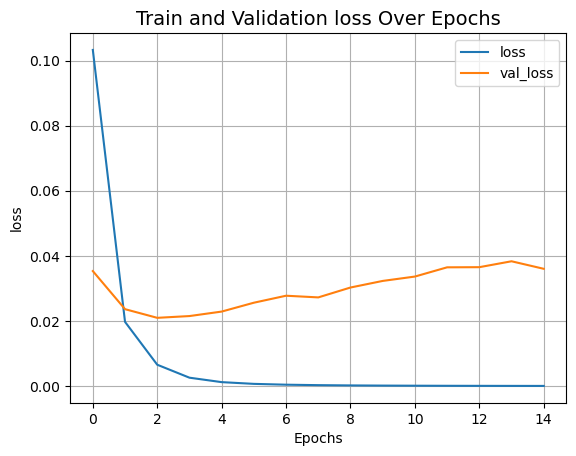

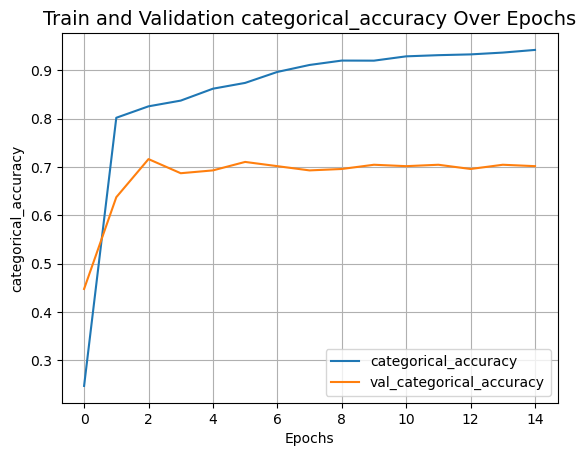

In [26]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

epochs = 15

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

While training, we notice an initial sharp fall in the loss followed by a gradual decay.

### Evaluate the model

In [27]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

3/3 [==============================] - 0s 11ms/step - loss: 0.0396 - categorical_accuracy: 0.6968
Categorical accuracy on the test set: 69.68%.


The trained model gives us an evaluation accuracy of ~87%.

## Inference

An important feature of the
[preprocessing layers provided by Keras](https://keras.io/guides/preprocessing_layers/)
is that they can be included inside a `tf.keras.Model`. We will export an inference model
by including the `text_vectorization` layer on top of `shallow_mlp_model`. This will
allow our inference model to directly operate on raw strings.

**Note** that during training it is always preferable to use these preprocessing
layers as a part of the data input pipeline rather than the model to avoid
surfacing bottlenecks for the hardware accelerators. This also allows for
asynchronous data processing.

In [28]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {decode_string(text)}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        (a,
        x)
        for a, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([str(x) + ' ' + label for x, label in top_3_labels])})")
    print(" ")

4/4 [==============================] - 0s 7ms/step
Abstract: ['Мягкие самоклеящиеся панели для стен/обои самоклеящиеся/LAKO DECOR/коллекция Классический кирпич, цвет Кофе, 70x77см, толщина 5мм Самоклеящиеся мягкие панели LAKO DECOR позволяют легко и быстро сделать косметический ремонт своими руками. Они подходят для декора стен, потолков и зонирования пространства, надёжно маскируют небольшие дефекты поверхностей. Объёмные 3D-панели удивительно просты в использовании: отделите защитный слой и прижмите клейкой стороной к поверхности! На монтаж одного блока у вас уйдёт несколько минут. Создавайте интерьеры любого стиля! LAKO DECOR предоставляет широкую линейку фактур: панели под кирпич, камень, дерево и др. Толщина – от 5 до 10 мм, в зависимости от модели. Самоклеящиеся панели изготовлены из качественных полимерных материалов, которые не имеют неприятного запаха. Они легко моются водой и спиртовыми растворами, обеспечивают дополнительную звукоизоляцию и теплоизоляцию, устойчивы к появлен

The prediction results are not that great but not below the par for a simple model like
ours. We can improve this performance with models that consider word order like LSTM or
even those that use Transformers ([Vaswani et al.](https://arxiv.org/abs/1706.03762)).

## Acknowledgements

We would like to thank [Matt Watson](https://github.com/mattdangerw) for helping us
tackle the multi-label binarization part and inverse-transforming the processed labels
to the original form.